# DigiPen Campus Agent

<a target="_blank" href="https://colab.research.google.com/github/simonguest/CS-394/blob/main/src/03/notebooks/campus-agent.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://github.com/simonguest/CS-394/raw/refs/heads/main/src/03/notebooks/campus-agent.ipynb">
  <img src="https://img.shields.io/badge/Download_.ipynb-blue" alt="Download .ipynb"/>
</a>

## Install pre-requisites

In [55]:
!uv pip install openai-agents==0.4.2 gradio==5.49.1

Using Python 3.12.12 environment at: /usr
Audited 2 packages in 128ms


## Agents

In [56]:
from agents import Agent, Runner, FileSearchTool, WebSearchTool

In [57]:
from google.colab import userdata
import os

OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY


### Cafe Agent

In [58]:
from agents import function_tool

@function_tool
def get_bytes_cafe_menu(date: str) -> any:
    return {
        f"{date}": {
            "daily byte": {
                "name": "Steak Quesadilla",
                "price": 12,
                "description": "Flank steak, mixed cheese in a flour tortilla served with air fried potatoes, sour cream and salsa",
            },
            "vegetarian": {
                "name": "Impossible Quesadilla",
                "price": 12,
                "description": "Impossible plant based product, mixed cheese in a flour tortilla served with air fried potatoes, sour cream and salsa",
            },
            "international": {
                "name": "Chicken Curry",
                "price": 12,
                "description": "Chicken thighs, onion, carrot, potato, curry sauce served over rice",
            },
        }
    }

In [59]:
cafe_agent = Agent(
    name="Cafe Agent",
    instructions="You help students locate and provide information about the Bytes Cafe.",
    tools=[
        get_bytes_cafe_menu,
    ],
)

### Set Vector Store

In [60]:
VECTOR_STORE_ID = "vs_697404ec396081919d426032714e23c8"

### Building Agent

In [61]:
building_agent = Agent(
    name="Building Agent",
    instructions="You help students locate and provide information about buildings and rooms on campus. Be descriptive when giving locations.",
    tools=[
        FileSearchTool(
            max_num_results=3,
            vector_store_ids=[VECTOR_STORE_ID],
            include_search_results=True,
        )
    ],
)

### Course Agent

In [62]:
course_agent = Agent(
    name="Course Agent",
    instructions="You help students find out information about courses held at DigiPen.",
    tools=[
        FileSearchTool(
            max_num_results=5,
            vector_store_ids=[VECTOR_STORE_ID],
            include_search_results=True,
        )
    ],
)

### Handbook Agent

In [63]:
handbook_agent = Agent(
    name="Handbook Agent",
    instructions="You help students navigate the school handbook, providing information about campus policies and student conduct.",
    tools=[
        FileSearchTool(
            max_num_results=5,
            vector_store_ids=[VECTOR_STORE_ID],
            include_search_results=True,
        )
    ],
)

### Counseling Service Agent

In [64]:
counseling_service_agent = Agent(
    name="Counseling Service Agent",
    instructions=(
        "You assist DigiPen students by providing clear, supportive information about the DigiPen Counseling Center. "
        "You explain available mental health services, eligibility, appointment scheduling, confidentiality policies, "
        "crisis support options, session limits, and how to contact the Counseling Center. "
        "You do NOT provide therapy or medical advice."
    ),
    tools=[
        WebSearchTool()
    ],
)



### Campus Agent

In [65]:
agent = Agent(
    name="DigiPen Campus Agent",
    instructions="You are a helpful campus agent that can plan and execute tasks for students at DigiPen. Please be concise and accurate in handing off tasks to other agents as needed. If the user mentions stress, anxiety, overwhelmed, burnout, panic, depression, loneliness, homesick, can't cope, or asks for emotional support → route to Counseling Service Agent.",
    handoffs=[building_agent, course_agent, handbook_agent, cafe_agent, counseling_service_agent],
)

## Gradio Interface

### Chat function and display of tool calls

In [66]:
from gradio import ChatMessage

async def chat_with_agent(user_msg: str, history: list):
    messages = [{"role": msg["role"], "content": msg["content"]} for msg in history]
    messages.append({"role": "user", "content": user_msg})
    responses = []
    reply_created = False
    active_agent = None

    result = Runner.run_streamed(agent, messages)
    async for event in result.stream_events():
        if event.type == "raw_response_event":
            if event.data.type == "response.output_text.delta":
                if not reply_created:
                    responses.append(ChatMessage(role="assistant", content=""))
                    reply_created = True
                responses[-1].content += event.data.delta
        elif event.type == "agent_updated_stream_event":
            active_agent = event.new_agent.name
            responses.append(
                ChatMessage(
                    content=event.new_agent.name,
                    metadata={"title": "Agent Now Running", "id": active_agent},
                )
            )
        elif event.type == "run_item_stream_event":
            if event.item.type == "tool_call_item":
                if event.item.raw_item.type == "file_search_call":
                    responses.append(
                        ChatMessage(
                            content=f"Query used: {event.item.raw_item.queries}",
                            metadata={
                                "title": "File Search Completed",
                                "parent_id": active_agent,
                            },
                        )
                    )
                else:
                    tool_name = getattr(event.item.raw_item, "name", "unknown_tool")
                    tool_args = getattr(event.item.raw_item, "arguments", {})
                    responses.append(
                        ChatMessage(
                            content=f"Calling tool {tool_name} with arguments {tool_args}",
                            metadata={"title": "Tool Call", "parent_id": active_agent},
                        )
                    )
            if event.item.type == "tool_call_output_item":
                responses.append(
                    ChatMessage(
                        content=f"Tool output: '{event.item.raw_item['output']}'",
                        metadata={"title": "Tool Output", "parent_id": active_agent},
                    )
                )
            if event.item.type == "handoff_call_item":
                responses.append(
                    ChatMessage(
                        content=f"Name: {event.item.raw_item.name}",
                        metadata={
                            "title": "Handing Off Request",
                            "parent_id": active_agent,
                        },
                    )
                )
        yield responses

### Launch Gradio

In [ ]:
import gradio as gr

demo = gr.ChatInterface(
    chat_with_agent,
    title="DigiPen Campus Agent",
    theme=gr.themes.Soft(
        primary_hue="red", secondary_hue="slate", font=[gr.themes.GoogleFont("Inter")]
    ),
    examples=[
        "I'm trying to find the WANIC classrooms. Can you help?",
        "What's the policy for eating in auditoriums?",
        "What's today's vegetarian dish at the Bytes Cafe?",
        "What are the prerequisites for FLM201?"
    ],
    submit_btn=True,
    flagging_mode="manual",
    flagging_options=["Like", "Spam", "Inappropriate", "Other"],
    type="messages",
    save_history=False,
)

demo.launch(share=False, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

# Project Analysis

## What agent you chose and why
I chose the Counseling Service Agent because many DigiPen students struggle with their classes, especially when they are starting college for the first time. Transitioning into college life can be overwhelming, and some students may not be able to handle the academic pressure on their own.

In addition, DigiPen has many international students from diverse backgrounds. Being alone in an unfamiliar culture can be challenging, and students may need additional support during this transition.

For this reason, I scoped this agent specifically to providing information about DigiPen’s counseling services, such as how to book an appointment and what resources are available. The agent does not provide medical advice or diagnose mental health conditions. In my opinion, the one-on-one session with a real human being is better than an AI agent even if they know what to do.


## How you implemented knowledge retrieval
I use a web search tool to allow the agent to retrieve counseling service information directly from the official DigiPen website. This enables the agent to provide accurate, up-to-date guidance on counseling policies and procedures.

With this approach, the agent can effectively help students understand how to seek support, where to find relevant information, and how to navigate the process of booking counseling services at DigiPen.








## Your test queries and the agent’s responses

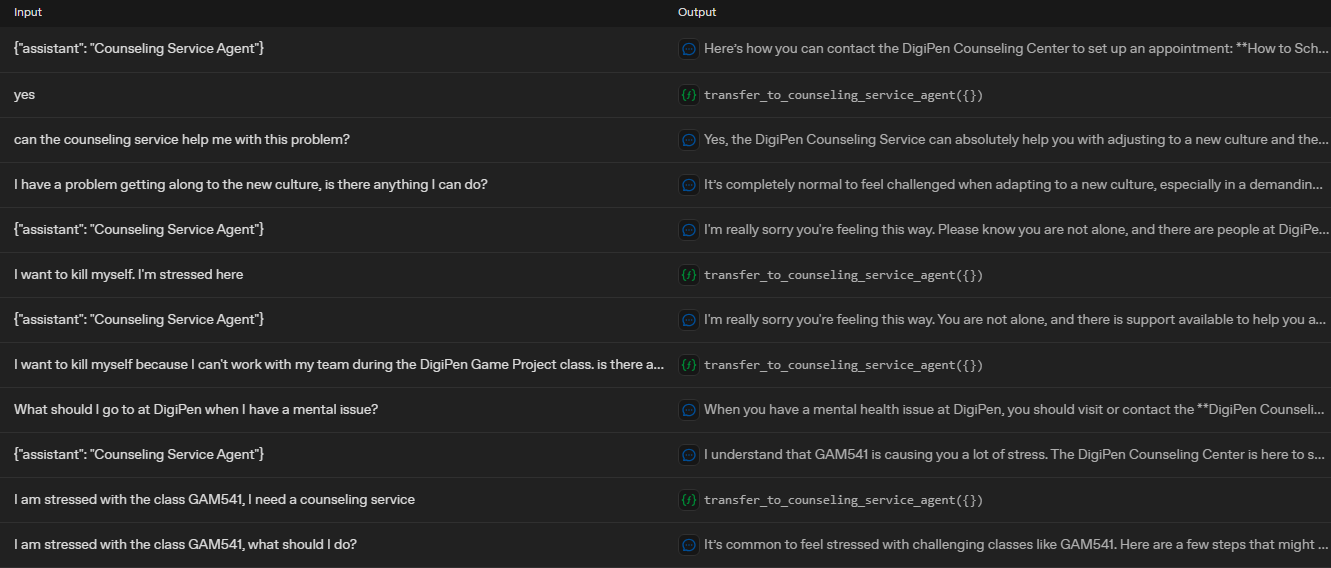





**Explanation**: All of the input prompts here were written by putting myself back into the emotional state I experienced when I was stressed and feeling sad during my game project. As you can see, the issue that sometimes occurs is that the system does not immediately route the request to the Counseling Service Agent.

## What you learned from the Traces Dashboard (what worked, what didn’t, any debugging insights)

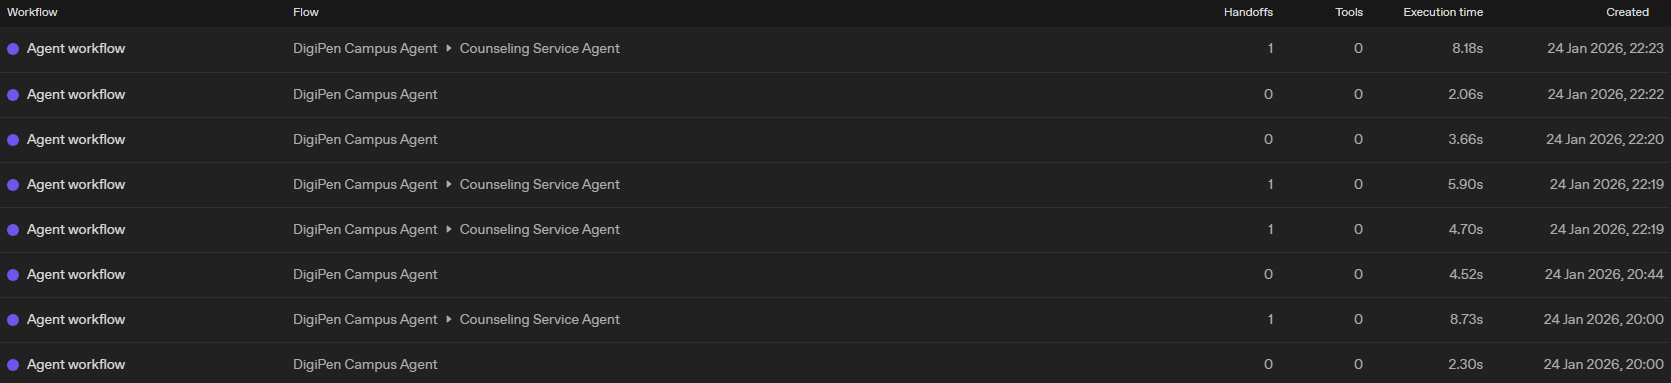

**Explanation**: What worked well in this setup is that the system does not invoke other agents’ models when queries include keywords related to mental health. This behavior is desirable, as it indicates that the agent correctly understands its intended role and scope.

However, one issue that remains is that for certain queries, the system occasionally hesitates or becomes uncertain about whether it should route the request to the Counseling Service Agent. This inconsistency suggests that the agent-selection logic could be further refined to improve confidence and reliability in agent invocation.

## Debugging Insights

For this prompt, I asked the agent, “I’m stressed with GAM541, what should I do?”
Instead of immediately directing the request to the Counseling Service Agent, the system tried to answer it on its own. I would like to understand how to debug this behavior.

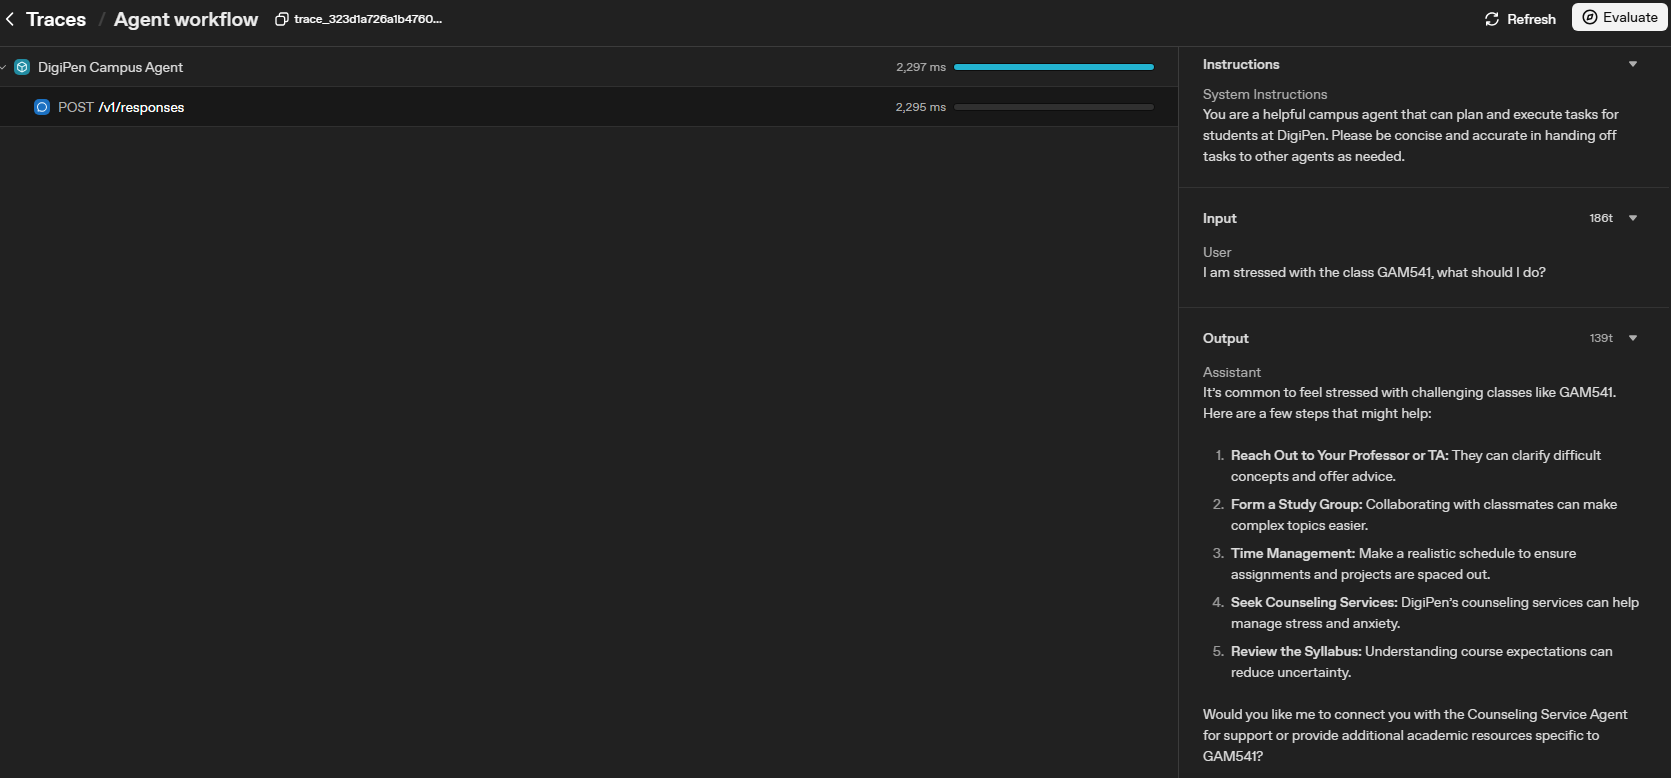

## Debugging

From this information, the **only possible issue** that I can see the **instruction**

> "You are a helpful campus agent that can plan and execute tasks for students at DigiPen. Please be concise and accurate in handing off tasks to other agents as needed."



So I tried to solve the problem by adding this line to the **instruction**

>  "If the user mentions stress, anxiety, overwhelmed, burnout, panic, depression, loneliness, homesick, can't cope, or asks for emotional support → route to Counseling Service Agent."



## Result
It works, the agent is calling the Counseling Service when I mentioned that "I'm stressed"

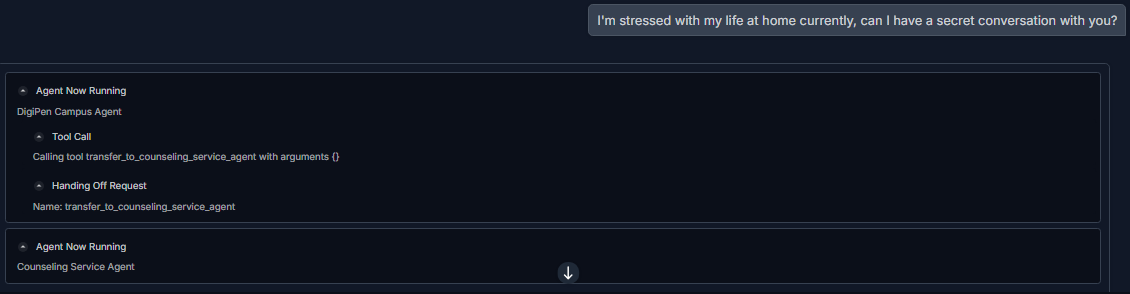